# 3 Neural Networks with Multiple Dimensional Input
<p>We'll implement Neural Networks (NN) with Multiple Dimensional Input.</p>
<p>Practice: NN with 1 Hidden Layer: Noisy XOR</p>
<ul>
    <li><a href="#data">Data</a></li>
    <li><a href="#model">Create the Model and Loss function: Cross Entropy</a></li>
    <li><a href="#training">Training</a></li>
    <li><a href="#results">Results</a></li>
</ul>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [2]:
# Helper function: plotting
def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

In [3]:
# Calculate the accuracy
def accuracy(model, data_set):
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

## <a name="data" id="data">Data</a>

In [4]:
# Define the class XOR_Data

class XOR_Data(Dataset):
    
    # Constructor
    def __init__(self, N_s=100):
        self.x = torch.zeros((N_s, 2))
        self.y = torch.zeros((N_s, 1))
        for i in range(N_s // 4):
            self.x[i, :] = torch.Tensor([0.0, 0.0]) 
            self.y[i, 0] = torch.Tensor([0.0])

            self.x[i + N_s // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + N_s // 4, 0] = torch.Tensor([1.0])
    
            self.x[i + N_s // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + N_s // 2, 0] = torch.Tensor([1.0])
    
            self.x[i + 3 * N_s // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * N_s // 4, 0] = torch.Tensor([0.0])

            self.x = self.x + 0.01 * torch.randn((N_s, 2))
        self.len = N_s

    # Getter
    def __getitem__(self, index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_stuff(self):
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")
        plt.legend()

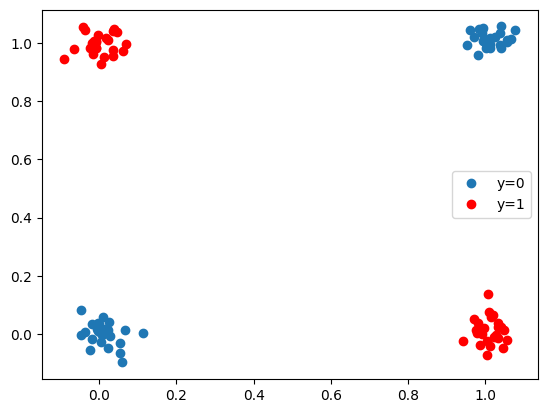

In [5]:
# Create dataset object

data_set = XOR_Data()
data_set.plot_stuff()

## <a name="model" id="model">Model: Neural network and loss criterion</a>

In [6]:
# Define the class Net with one hidden layer 
class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        #hidden layer 
        self.linear1 = nn.Linear(D_in, H)
        #output layer 
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))  
        x = torch.sigmoid(self.linear2(x))
        return x

In [7]:
# Define the Neural Network, Criterion, and Optimizer:
torch.manual_seed(0)

# NN: 1 neuron in the hidden layer. Loss: BCE. Optimizer: SGD.
model = Net(2, 1, 1)

learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loader = DataLoader(dataset=data_set, batch_size=1)

## <a name="training" id="training">Training</a>
**May take a few minutes**

In [8]:
# Define the train model

def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    COST = []
    ACC = []
    for epoch in range(epochs):
        total=0
        for x, y in train_loader:
            optimizer.zero_grad()
            
            y_hat = model(x)
            
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #cumulative loss 
            total+=loss.item()
            
        ACC.append(accuracy(model, data_set))
        COST.append(total)
        
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

    return COST

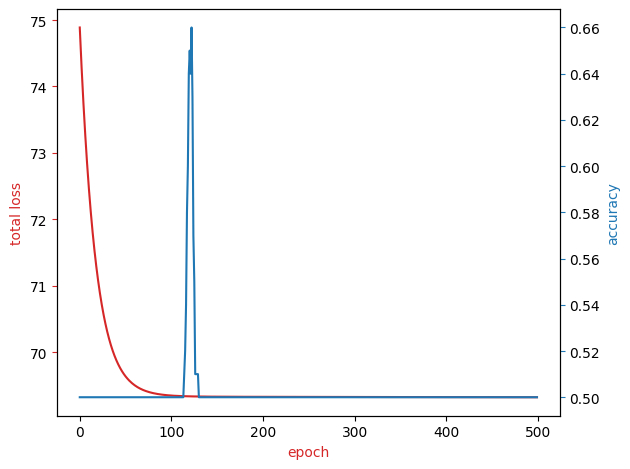

In [9]:
COST_1 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)

## <a name="results" id="results">Results</a>

Text(0, 0.5, 'x1')

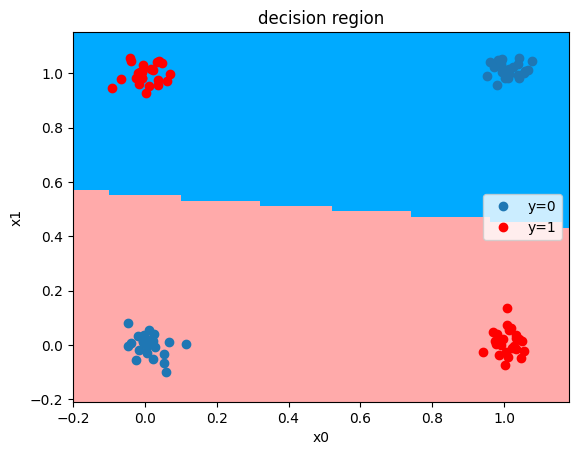

In [13]:
# Plot the loss
plot_decision_regions_2class(model, data_set)
plt.xlabel('x0')
plt.ylabel('x1')

We can try different network configurations.

For example, 2 Hidden layers:  `model = Net(2, 2, 1)`
